In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

os.chdir("../../")
from pathlib import Path
import matplotlib.gridspec as gridspec

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "c"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
print(len(X_df_FULL.columns))

112


In [5]:
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]

bigdf = X_df.join(y_df)

## 0. Scatter/histogram b/w individual features

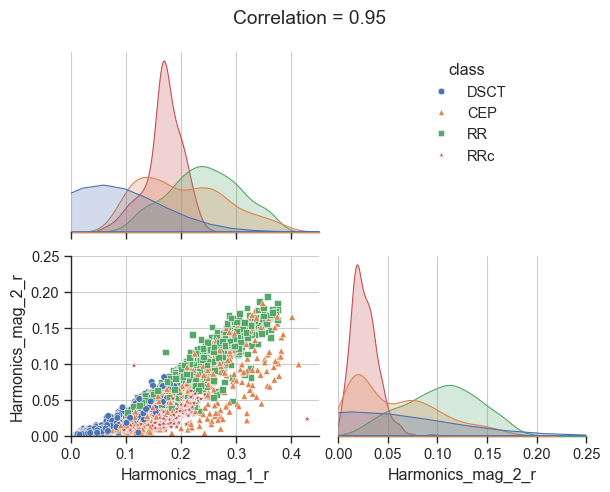

In [6]:
corr_matrix = X_df.corr()
vars_interest = ["Harmonics_mag_1_r", "Harmonics_mag_2_r"]
corr_val = corr_matrix.loc[vars_interest[0], vars_interest[1]]
ax = sns.pairplot(
    bigdf,
    vars=vars_interest,
    hue="class",
    corner=True,
    markers=["o", "^", "s", "*"],
)
plt.suptitle(f"Correlation = {corr_val:.2f}")
plt.tight_layout()
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.675, 0.9))
# https://stackoverflow.com/a/34579525/10743245

var1_lims = (0, 0.45)
var2_lims = (0, 0.25)

ax.axes.ravel()[0].set_xlim(*var1_lims)
ax.axes.ravel()[2].set_xlim(*var1_lims)
ax.axes.ravel()[2].set_ylim(*var2_lims)
ax.axes.ravel()[3].set_xlim(*var2_lims)

Path("results", results_subfolder).mkdir(parents=True, exist_ok=True)
plt.savefig(
    os.path.join("results", results_subfolder, "harmonics_corr.pdf"),
    bbox_inches="tight",
)
plt.show()

## 1. Remove all g features. Keep r and multiband only

In [7]:
## REMOVE g-band features. Keep r-band and multiband features only

gband_features = []
for c in X_df_FULL.columns:
    if c.endswith("_g"):
        gband_features.append(c)
    else:
        continue

In [8]:
len(gband_features)

52

## 2. Manually inspect feature descriptions and remove

In [9]:
newdf = pd.read_csv("data/.temp_feature_description", index_col=0)

# Go to the following link for interactive spreadsheet
# https://docs.google.com/spreadsheets/d/1EDzk51Nzk6jhGbZhimN3iQiRkba_NCRN6Uoxi6eTzoU/

newdf

,KEEP?,Reason,Description,Source,"bands (g, r, or multiband)"
Feature name,,,,,
Amplitude,YES,Because different classes have different ampli...,Half of the difference between the median of t...,ALeRCE,g and r
AndersonDarling,YES,Different classes may have light curves that c...,Test of whether a sample of data comes from a ...,ALeRCE,g and r
Autocor_length,YES,Because the autocorrelation can be different f...,Lag value where the auto-correlation function ...,ALeRCE,g and r
Beyond1Std,YES,Because this tells us how many points suddenly...,Percentage of points with photometric mag that...,ALeRCE,g and r
Con,NO,"Irregular time series, so number of points bad...",Number of three consecutive data points bright...,ALeRCE,g and r
delta_period,NO,"Just tells us about different fits, nothing ab...",Absolute value of the difference between the M...,ALeRCE,g and r
Eta_e,YES,Measures trend of lightcurve degree of variaba...,Ratio of the mean of the squares of successive...,ALeRCE,g and r
ExcessVar,YES,Measures intrinsic variability,Measure of the intrinsic variability amplitude...,ALeRCE,g and r
GP_DRW_sigma,YES,Measures variability at short timescales,Amplitude of the variability at short timescal...,ALeRCE,g and r


In [10]:
# Remove manually selected 'bad' features
bad_features = [
    "Con_r",
    "delta_period_r",
    "Harmonics_mse_r",
    "MaxSlope_r",
    "MHPS_PN_flag_r",
    "PairSlopeTrend_r",
    "MHPS_non_zero_r",
    "iqr_r",
    "Multiband_period",
    "Power_rate_1/2",
    "Power_rate_1/3",
    "Power_rate_1/4",
    "Power_rate_2",
    "Power_rate_3",
    "Power_rate_4",
    "PPE",
]  # manually selected

In [11]:
len(bad_features)

16

## 3. Drop features having a high correlation in the full dataset for this quaternary classification problem

In [12]:
corr_thresh = 0.9

In [13]:
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]

cl_keep_str = "_".join(classes_to_keep)

# Remove feats from (1) and (2) and keep only 4 classes
y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df_FULL = X_df_FULL.drop(bad_features, axis=1).drop(gband_features, axis=1)
X_df = X_df_FULL.loc[y_df.index]
bigdf = X_df.join(y_df)

In [14]:
# Compute the correlation matrix
corr_matrix = X_df.loc[:, sorted(X_df.columns)].corr().abs()

In [15]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype("bool"))

In [16]:
upper = upper[upper >= corr_thresh].dropna(axis=1, how="all")
upper = upper.sort_values(by=list(upper.columns), ascending=False)

In [17]:
lists = []

for idx in upper.index:
    row = upper.loc[idx].dropna()
    ls = sorted(list(row.index) + [row.name])
    lists.append(ls)

We only want to keep one feature for each subset of features that are highly correlated.

In [18]:
# lists = [[1, 3], [3, 5], [5, 6], [7, 8]]
merged = []
for lst in lists:
    for m in merged:
        if any(item in m for item in lst):
            m.extend(lst)
            break
    else:
        merged.append(lst)

merged_alt = []
for m in merged:
    merged_alt.append(list(set(m)))
merged = merged_alt
# print(merged)

In [19]:
for m in merged:
    if len(m) > 1:
        print("\n\t".join(m))
        print("*" * 10)

Amplitude_r
	GP_DRW_sigma_r
	MedianAbsDev_r
	Std_r
	SF_ML_amplitude_r
	ExcessVar_r
	Meanvariance_r
	Q31_r
**********
Harmonics_mag_2_r
	Harmonics_mag_3_r
	Harmonics_mag_4_r
	Harmonics_mag_6_r
	Harmonics_mag_1_r
	Harmonics_mag_5_r
**********
Pvar_r
	GP_DRW_tau_r
**********


In [20]:
# manually choose one from each subset
# edit - choose the one with the highest SNR or the one with the STD
# alternate programmatic approach - look at diff clusters
choose_corrfeats = ["Amplitude_r", "Harmonics_mag_1_r", "GP_DRW_tau_r"]

In [21]:
bigset = []
for m in merged:
    if len(m) > 1:
        bigset.append(m)
bigset = [item for subset in bigset for item in subset]

drop_corrfeats = list(set(bigset) - set(choose_corrfeats))

In [22]:
len(drop_corrfeats)

13

## 4. Combine and drop all features

In [23]:
drop_features = (
    list(sorted(gband_features))
    + list(sorted(bad_features))
    + list(sorted(drop_corrfeats))
)

In [24]:
# Drop duplicates while preserving order
drop_features = list(dict.fromkeys(drop_features))

In [25]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

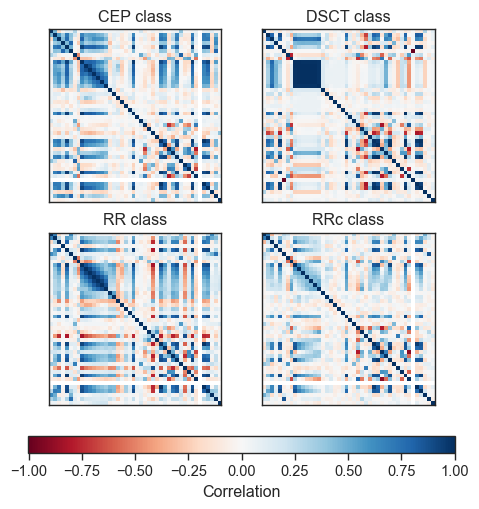

In [26]:
fig = plt.figure(figsize=(5.5, 5.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.1], hspace=0.25, wspace=0)

axs = [
    plt.subplot(gs[0, 0]),
    plt.subplot(gs[0, 1]),
    plt.subplot(gs[1, 0]),
    plt.subplot(gs[1, 1]),
    plt.subplot(gs[2, :]),
]

for (cl, subdf), ax in zip(bigdf.groupby("class"), axs[:4]):
    corr_matrix = subdf.drop(["class"], axis=1).corr(method="pearson")

    im = ax.imshow(corr_matrix, cmap="RdBu", clim=(-1, 1))
    ax.set_title(f"{cl} class")
    ax.grid()
    ax.set_xticks([])
    ax.set_yticks([])

# Create a colorbar
cbar = plt.colorbar(im, cax=axs[4], orientation="horizontal")
cbar.set_label("Correlation")

# axs[4].axis('off')  # Turn off the axis for the colorbar subplot

# plt.tight_layout()
plt.savefig(
    os.path.join("results", results_subfolder, "corr_matrix_before.pdf"),
    bbox_inches="tight",
)
plt.show()

In [27]:
print(f"Original no. of features: {X_df_FULL.shape[1]}")
X_df_FULL = X_df_FULL.drop(drop_features, axis=1)
print(f"Reduced no. of features: {X_df_FULL.shape[1]}")

Original no. of features: 112
Reduced no. of features: 31


In [28]:
X_df = X_df_FULL.loc[y_df.index]
bigdf = X_df.join(y_df)

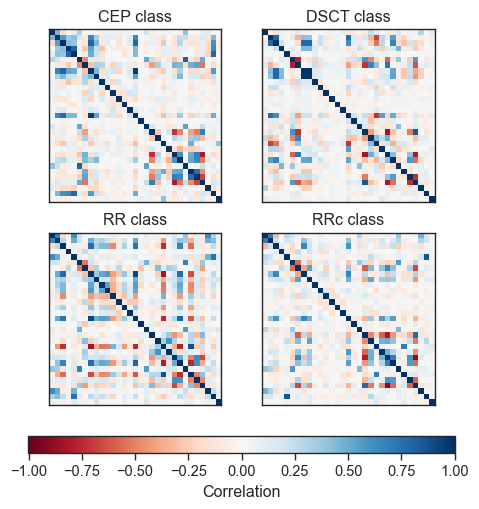

In [29]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(5.5, 5.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.1], hspace=0.25, wspace=0)

axs = [
    plt.subplot(gs[0, 0]),
    plt.subplot(gs[0, 1]),
    plt.subplot(gs[1, 0]),
    plt.subplot(gs[1, 1]),
    plt.subplot(gs[2, :]),
]

for (cl, subdf), ax in zip(bigdf.groupby("class"), axs[:4]):
    corr_matrix = subdf.drop(["class"], axis=1).corr(method="pearson")

    im = ax.imshow(corr_matrix, cmap="RdBu", clim=(-1, 1))
    ax.set_title(f"{cl} class")
    ax.grid()
    ax.set_xticks([])
    ax.set_yticks([])

# Create a colorbar
cbar = plt.colorbar(im, cax=axs[4], orientation="horizontal")
cbar.set_label("Correlation")

# axs[4].axis('off')  # Turn off the axis for the colorbar subplot

# plt.tight_layout()
plt.savefig(
    os.path.join("results", results_subfolder, "corr_matrix_after.pdf"),
    bbox_inches="tight",
)
plt.show()

In [30]:
import json

with open(os.path.join("results", results_subfolder, "drop_features.txt"), "w") as f:
    json.dump(drop_features, f, indent=2)